## 라이브러리 불러오기

In [1]:
# API 호출
# ## https://data.go.kr/tcs/dss/selectApiDataDetailView.do?publicDataPk=15057440
from urllib.request import Request, urlopen
# Request https://docs.python.org/ko/3/library/urllib.request.html#urllib.request.Request
# urlopen https://docs.python.org/ko/3/library/urllib.request.html#urllib.request.urlopen
from urllib.parse import urlencode, quote_plus
# urlenocde https://docs.python.org/ko/3/library/urllib.parse.html#urllib.parse.urlencode
# quote_plus https://docs.python.org/ko/3/library/urllib.parse.html#urllib.parse.quote_plus
from urllib.parse import unquote
import requests

# 시간 생성
import time
import datetime
from pytz import timezone, utc

# 폴더 자동 생성
import os

# 코드 스케줄링
import threading
# import schedule

# XML 파싱
import xml.etree.ElementTree as ET

# 입력데이터 데이터프레임 작성
import pandas as pd
import numpy as np

# DataFrame 화면 출력                                                # DataFrame 화면 출력 설정이 변경되어 있습니다 #
from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_rows = None # default = 60

#EXCEL
import openpyxl

# 배차간격 확인 scatter plot 출력
import matplotlib.pyplot as plt

In [2]:
# 폴더 자동 생성 함수
# https://data-make.tistory.com/170
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

## 기본값 설정하기

In [3]:
def todayStr(year:int, month:int, day:int) -> str:
    todayDateTimeStr = f"{year}-{month}-{day}"
    return todayDateTimeStr

## Key Unquote

In [4]:
KEY = 'yEaR%2F3MDedRSlVJL%2F2pxnVg0yre1N5VF3RZ%2FUAt56MJ7J2mNpfqhUvy05pXV0uhHTVY7DbyCR8xmMaDdYga67Q%3D%3D' # 종현
apiKey = unquote(KEY)

## API 호출

In [5]:
"""
노선정보항목조회 busrouteservice/info
routeId의 정류장 목록을 받아옵니다.
"""
def apiInfo(routeId, service='station'):
    url = 'http://openapi.gbis.go.kr/ws/rest/busrouteservice/'
    url += service
    
    queryParams = '?' + urlencode({ quote_plus('serviceKey') : apiKey, quote_plus('routeId') : routeId })
    request = Request(url + queryParams)
    request.get_method = lambda: 'GET'

    # API를 호출하여 XML 형식으로 된 string 데이터를 변수 "oneLineXML" 에 저장합니다.
    oneLineXML = urlopen(request).read().decode('utf8')
    return oneLineXML

## XML 파싱

In [6]:
def makeInfoDf(routeId:int):
    oneLineXML = apiInfo(routeId)

    # xtree는 "openapi" 도메인 API 호출에서 "headerCd"에 상관없이 3개의 태그를 갖습니다.
    # [comMsgHeader, msgHeader, msgBody]
    xtree = ET.fromstring(oneLineXML)
    # for branch in xtree:
    #     print(branch)
    msgBody = xtree[2]

    tagList = ["centerYn", "districtCd", "regionName", "stationId", "stationName", "x", "y", "stationSeq", "turnYn"]
    stationList = []
    for branch in msgBody:
        subList = [branch.find(tag).text for tag in tagList]
        try:
            subList.append(branch.find("mobileNo").text.lstrip())
        except:
            subList.append('-1')
        stationList.append(subList)

    # station_df의 index가 0부터 시작하는 문제를 해결 하기 위해 rangeIndex를 지정하였습니다.
    stationCount = len(stationList) # 뒤에서 다시 사용되므로 함수로 선언시 주의
    rangeIndex = pd.RangeIndex(start=1, stop=stationCount+1)
    
    tagList.append("mobileNo")
    station_df = pd.DataFrame(stationList, columns=tagList, index=rangeIndex)
    station_df = station_df.astype({
                                    "centerYn" : "string",
                                    "districtCd" : "int32",
                                    "regionName" : "string",
                                    "stationId" : "int32",
                                    "stationName" : "string",
                                    "x" : "float",
                                    "y" : "float",
                                    "stationSeq" : "int",
                                    "turnYn" : "string",
                                    "mobileNo" : "string",
                                    })
    return station_df

In [7]:
def makeLineDf(routeId:int):
    oneLineXML = apiInfo(routeId, 'line')
    
    xtree = ET.fromstring(oneLineXML)
    msgBody = xtree[2]
    
    tagList = ["lineSeq", "x", "y"]
    busRouteLineList = []
    for branch in msgBody:
        busRouteLineList.append([branch.find(tag).text for tag in tagList])

    pointCount = len(busRouteLineList)
    rangeIndex = pd.RangeIndex(start=1, stop=pointCount+1)

    line_df = pd.DataFrame(busRouteLineList, columns=tagList, index=rangeIndex)
    line_df = line_df.astype({
                                "lineSeq" : "int32",
                                "x" : "float",
                                "y" : "float"
    })
    return line_df

In [8]:
def makeRangeIndex(station_df):
    return station_df.index

## 샘플데이터

In [9]:
routeId = 234000130

In [10]:
line_df = makeLineDf(routeId)
station_df = makeInfoDf(routeId)

In [11]:
half = len(line_df)//2
half_station = len(station_df)//2

In [46]:
half_station

76

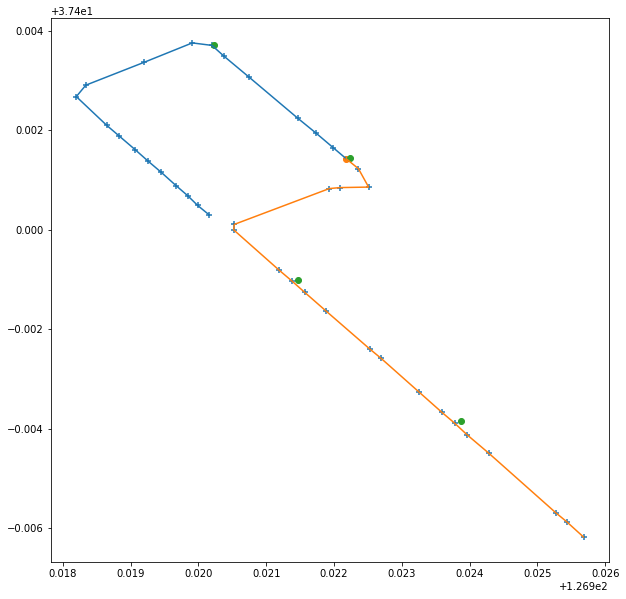

In [12]:
plt.figure(figsize=(10, 10))
plt.plot(line_df['x'].iloc[half:half+20],line_df['y'].iloc[half:half+20])
plt.plot(line_df['x'].iloc[half-20:half+1],line_df['y'].iloc[half-20:half+1])
plt.scatter(line_df['x'].iloc[half-20:half+20],line_df['y'].iloc[half-20:half+20], marker='+')
plt.scatter(line_df['x'].iloc[half],line_df['y'].iloc[half])
plt.scatter(station_df['x'].iloc[half_station-2:half_station+2],station_df['y'].iloc[half_station-2:half_station+2])
plt.show()

## line_df의 점을 하나씩 접근 하는 방법과 문제점

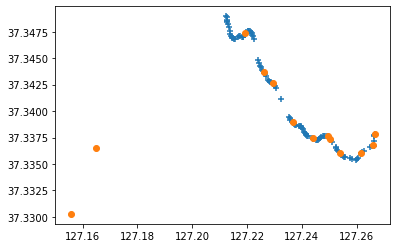

In [13]:
plt.scatter(line_df['x'][:120], line_df['y'][:120], marker='+')
plt.scatter(station_df['x'][:13], station_df['y'][:13])
plt.show()

In [14]:
# !pip3 install haversine
from haversine import haversine

In [15]:
def distance(sx, sy, lx, ly):
    #_point_diff = np.array([sx-lx, sy-ly]) #편차
    #_dist = (_point_diff ** 2).sum() #제곱의 합
    #dist = np.sqrt(_dist)
    dist = haversine((sy, sx), (ly, lx)) * 1000
    return dist # 기준거리

### 유클리드거리와 맨하탄거리의 차이에서 발생하는 문제점

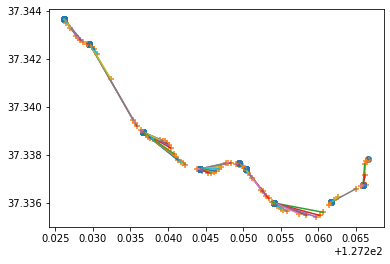

In [16]:
j = 0
(sx, sy) = station_df.iloc[j][['x', 'y']]
# /print sx sy
preDist = -1
sumDist = 0
sumDistList = []
for lineIndex in line_df.index[:80]:
    # print(f"lineIndex: {lineIndex}")
    (lx, ly) = line_df.iloc[lineIndex-1][['x', 'y']]
    nextDist = distance(sx, sy, lx, ly)
    # print(f"preDist: {preDist:.2f}")
    # print(f"nextDist: {nextDist:.2f}")
    # plt.plot([(sx, sy),(lx, ly)])
    plt.scatter(sx, sy, c='#1f77b4')

    plt.scatter(lx, ly, marker='+', c='#ff7f0e')
    # /print '(lx,ly): ' lx ly
    plt.plot([lx,sx],[ly,sy])


    if(preDist > nextDist):
        sumDist += nextDist
        preDist = nextDist
        
    else:
        # 다음 station point
        j+=1
        #print(f"j: {j}, lineIndex: {lineIndex}")

        (sx, sy) = station_df.iloc[j][['x', 'y']]
        # /print '(sx,sy): ' sx sy

        # 누적거리를 리스트(or DaFr)에 추가하고, 초기화
        sumDistList.append(sumDist)
        # /print sumDist
        sumDist = 0
        preDist = 99999999
    # /print '\n'

## 최단거리 포인트를 찾는 방법

In [17]:
distanceList = []
(sx, sy) = station_df.iloc[3][['x', 'y']]

for i in range(29):
    (lx, ly) = line_df.iloc[i][['x', 'y']]
    dist = distance(sx, sy, lx, ly)
    #print(i, dist)
    distanceList.append(dist)

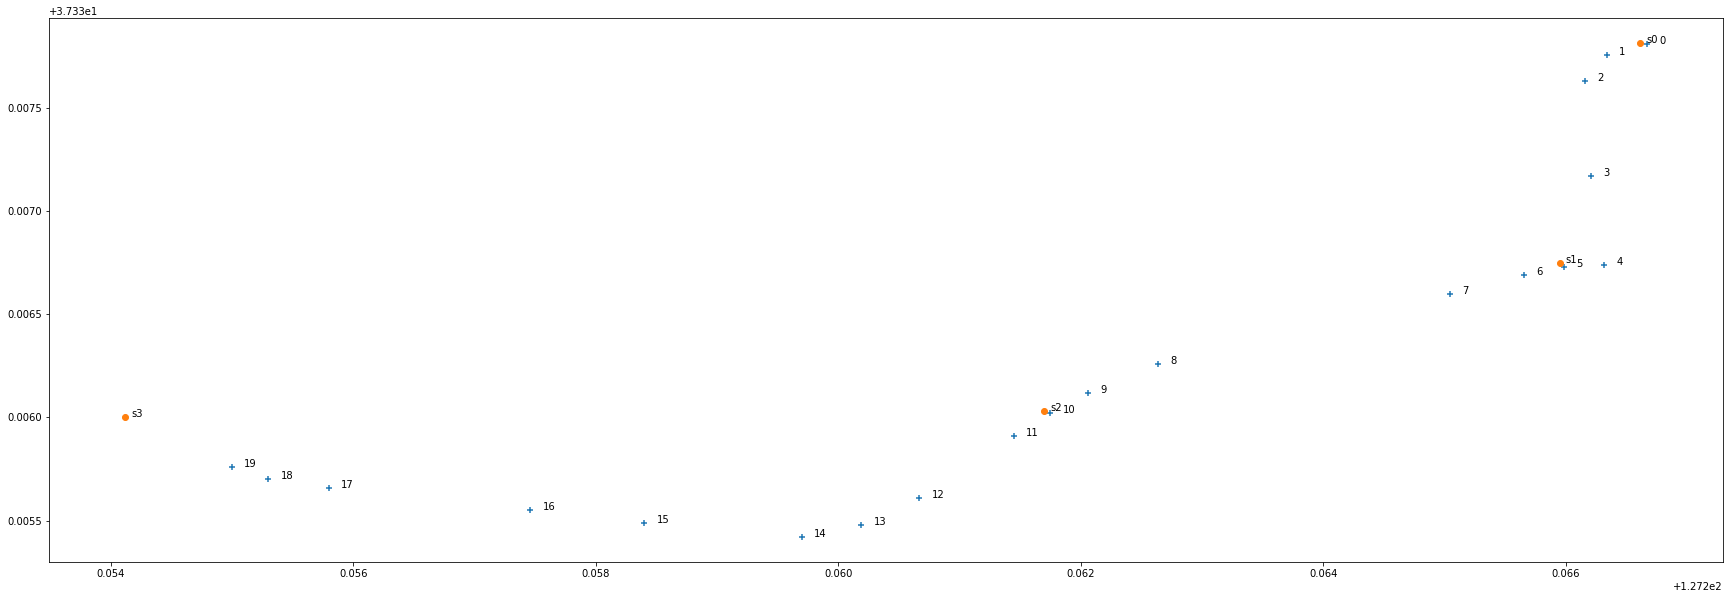

In [18]:
plt.figure(figsize=(30, 10))
lineIndex = 0
maxIndex = 0

plt.scatter(line_df['x'][lineIndex:lineIndex+20], line_df['y'][lineIndex:lineIndex+20], marker='+')
for i in range(lineIndex, lineIndex+20):
    plt.text(line_df['x'].iloc[i]+0.0001, line_df['y'].iloc[i], f'{i}', fontsize=10)
plt.scatter(station_df['x'][maxIndex:maxIndex+4], station_df['y'][maxIndex:maxIndex+4])
for i in range(maxIndex, maxIndex+4):
    plt.text(station_df['x'].iloc[i]+0.00005, station_df['y'].iloc[i]+0.0000, f's{i}')
plt.show()

In [40]:
stationIndexList = []
lastIndex = 0
K = 100
for i in station_df.index:
#     print(f"station index: {i}")

    distList = []
    indexList = []
    

    for j in range(lastIndex, lastIndex + K):
        if(j >= len(line_df)):
            break
        (sx, sy) = station_df.iloc[i-1][['x', 'y']]
        (lx, ly) = line_df.iloc[j][['x', 'y']]
        dist = distance(sx, sy, lx, ly)
#         print(f"\tj: {j:3d}\tdist: {dist}")

        distList.append(dist)
        indexList.append(j)

    tempIndex = np.argmin(np.array(distList))
    lastIndex = indexList[tempIndex]

#     print(f"lastIndex: {lastIndex}")

    stationIndexList.append(lastIndex)

### 실제 정류장 위치와 예측 정류장 위치 비교 plot

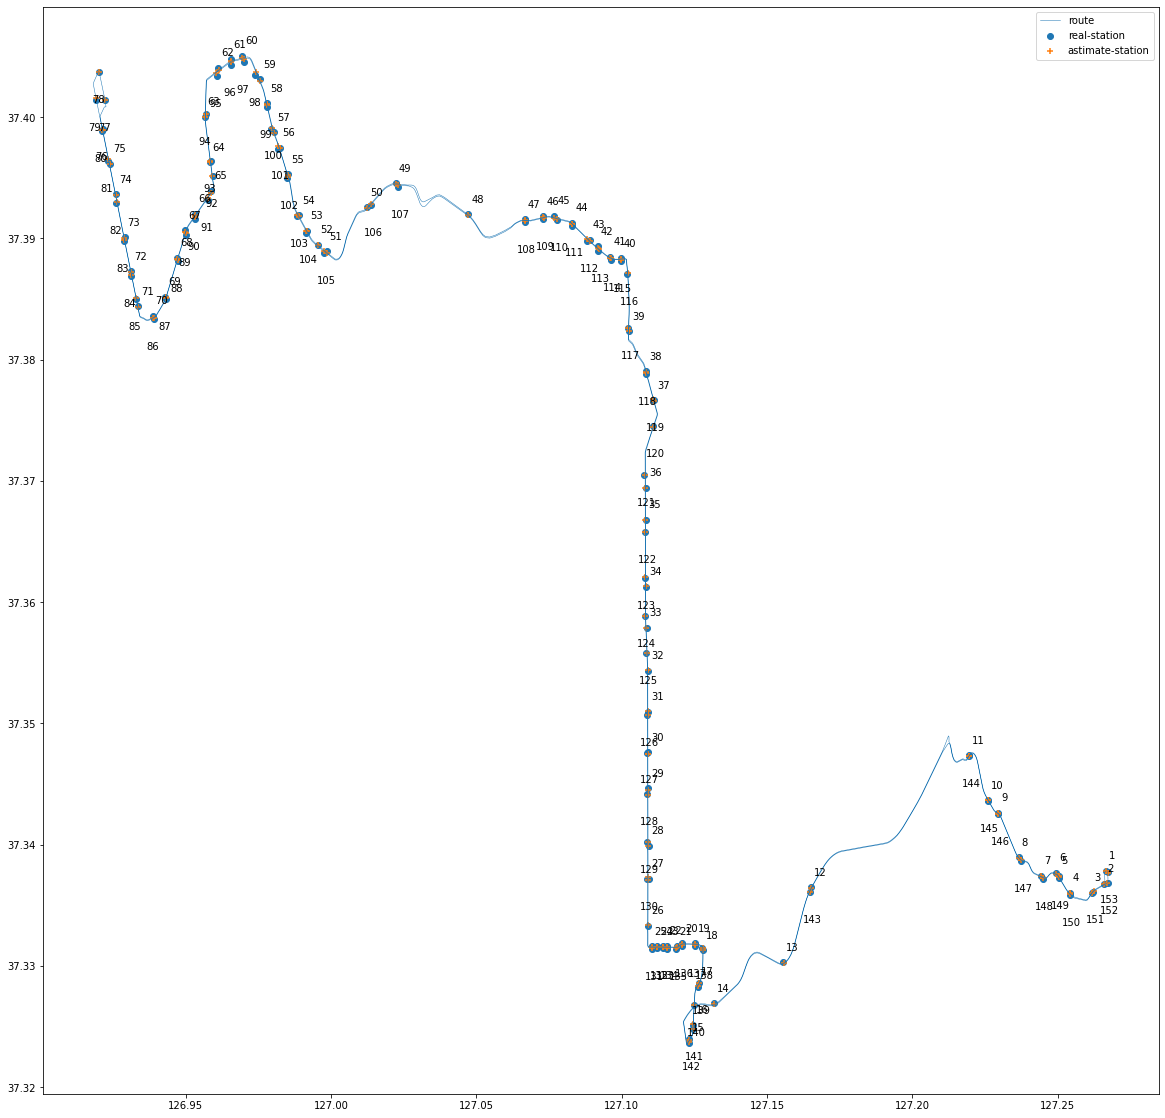

In [41]:
plt.figure(figsize=(20, 20))
lsx = line_df.iloc[stationIndexList]['x']
lsy = line_df.iloc[stationIndexList]['y']
sx = station_df['x']
sy = station_df['y']
lx = line_df['x']
ly = line_df['y']
plt.plot(lx, ly, linewidth='.5')
plt.scatter(sx, sy)
plt.scatter(lsx, lsy, marker = '+')
plt.legend(['route', 'real-station', 'astimate-station'])


for i in station_df.index:
    if(i < len(station_df)//2):
        sig = 1
    else:
        sig = -2.5
    plt.text(station_df['x'].iloc[i-1]+0.001*sig, station_df['y'].iloc[i-1]+0.001*sig, f'{i}')
plt.show()

## 구간별 거리 계산

In [42]:
sumDist = 0
distList = [0]
j=1
for i in range(len(line_df)-1):
    if(i+1 == stationIndexList[j]+1):
        distList.append(sumDist)
        sumDist = 0
        j += 1
    (pre_x, pre_y) = line_df[['x', 'y']].iloc[i]
    (next_x, next_y) = line_df[['x', 'y']].iloc[i+1]
    partDist = distance(pre_x, pre_y, next_x, next_y)
#     /print i+1 partDist
    sumDist += partDist
distList.append(sumDist)

In [43]:
assert len(distList) == len(station_df)

AssertionError: 

In [45]:
len(station_df)

153

In [ ]:
totalDist = 0
for i in range(len(line_df)-1):
    (_pre_x, _pre_y) = line_df[['x', 'y']].iloc[i]
    (_next_x, _next_y) = line_df[['x', 'y']].iloc[i+1]
    stationDist = distance(_pre_x, _pre_y, _next_x, _next_y)
    totalDist += stationDist
    
assert np.round(totalDist, 9) == np.round(sum(distList),9)

In [ ]:
# plt.figure(figsize=(10, 10))
plt.scatter(line_df['x'].iloc[:13], line_df['y'].iloc[:13],marker='+')
for i in range(14):
    plt.text(line_df['x'].iloc[i-1], line_df['y'].iloc[i-1], f'{i-1}')
plt.plot(line_df['x'].iloc[:13], line_df['y'].iloc[:13], linewidth=.5)
# plt.scatter(line_df['x'].iloc[[5, 11]], line_df['y'].iloc[[5, 11]])
plt.scatter(station_df['x'].iloc[0:3], station_df['y'].iloc[0:3])
plt.show()

In [ ]:
station_df['distance'] = distList

## 누적거리를 계산한다

In [ ]:
# 누적합을 구하는 pandas dataframe method
accumList = pd.DataFrame(distList).cumsum()

In [34]:
"""
accumList = []
accumDist = 0
for dist in distList:
    accumDist += dist
    accumList.append(accumDist)
"""
pass

In [ ]:
station_df['accumDistance'] = accumList

## station_df를 csv파일로 내보낸다

In [32]:
root = os.getcwd()
outFolder = root + '/out/' + str(routeId)
rangeNum = '/r1/'
folderPath = outFolder + rangeNum
createFolder(folderPath)
fileName = 'station_df'
filePath = folderPath + fileName +'.csv'

station_df.to_csv(filePath, index=False)

In [34]:
# station_df

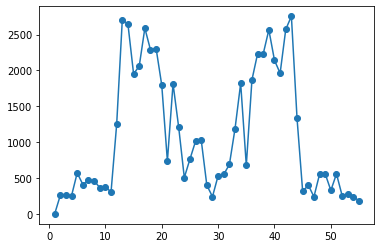

In [35]:
plt.plot(station_df['distance'].index, station_df['distance'])
plt.scatter(station_df['distance'].index, station_df['distance'])

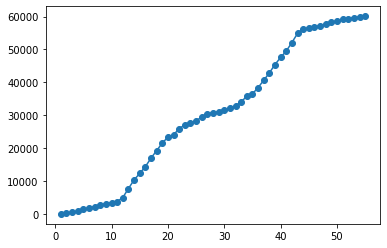

In [36]:
plt.plot(station_df['accumDistance'].index, station_df['accumDistance'])
plt.scatter(station_df['accumDistance'].index, station_df['accumDistance'])
plt.show()

In [ ]:
np.array(station_df['distance']).round(-1)